In [1]:
from gensim.models import Doc2Vec
from sklearn import decomposition
import numpy as np  
import sys
import operator
from sklearn import metrics
from sklearn import preprocessing
from sklearn import cross_validation

import heapq
import pandas as pd
import random as rnd
from random import shuffle
import collections
import matplotlib.ticker as ticker

from heapq import nlargest

from twitch import commons

%pylab inline
matplotlib.use('Agg')
import matplotlib
import matplotlib.pyplot as plt

# fig_size = plt.rcParams["figure.figsize"]
# fig_size[0] = 12
# fig_size[1] = 9
# plt.rcParams["figure.figsize"] = fig_size

import matplotlib.pylab as pylab

# params = {'legend.fontsize': 'xx-large',
#           'axes.labelsize': 'xx-large',
#           'axes.titlesize': 'xx-large',
#           'xtick.labelsize': 'xx-large',
#           'ytick.labelsize': 'xx-large'}

# pylab.rcParams.update(params)

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy
//anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [12]:
df = pd.read_csv('./user_chat_counts.csv.dat', header=None, names=['user', 'total', 'male', 'female'])
df['female_chat_percentage'] = (df.female*100)/df.total

print('all users: ' + str(len(df.index)))

print('users with atleast 100 messages: ' + str(len(df[df.total >= 100].index)))

all_users = df[(df.total >= 100)]
selected_users = df[(df.total >= 100) & ((df.female_chat_percentage == 100) | (df.female_chat_percentage == 0))]
users = selected_users.user.tolist()
female_chat_percentages = selected_users.female_chat_percentage.tolist()

no_of_users = len(users)
print('filtered users: ' + str(no_of_users))

all users: 1684452
users with atleast 100 messages: 77027
filtered users: 35588


In [13]:
all_users['male_chat_percentage'] = 100 - all_users.female_chat_percentage

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [14]:
all_users['male_chat_percentage'] = all_users['male_chat_percentage'].astype(int)
all_users['female_chat_percentage'] = all_users['female_chat_percentage'].astype(int)

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [15]:
model = Doc2Vec.load('./user_all_chats.d2v')

In [16]:
len(model.index2word)

13888

In [19]:
non_normalized_feature_vectors = [model.docvecs[x] for x in users]

feature_vectors = preprocessing.normalize(preprocessing.scale(non_normalized_feature_vectors))

In [20]:
print(len(feature_vectors))

35588


### classification model

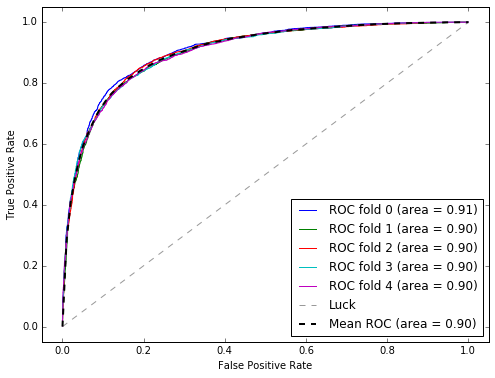

Accuracy: 0.83 (+/- 0.01)


In [26]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 8
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size

y = np.array([1 if female_chat_percentages[i] >= 50 else 0 for i in range(len(feature_vectors))])
(lr, coef, _) = commons.build_lr_classification_model_cv(feature_vectors, y, 5)

### Words which has the highest & lowers probability with trained logistic regression (from frequent 100,000 words)

In [27]:
all_words_dic = commons.read_word_count_file("../../data/word_counts/global_word_counts.csv")
all_words_list = sorted(all_words_dic.items(), key=operator.itemgetter(1), reverse=True)

In [28]:
selected_word_vectors = []
selected_words = []
count = 0
for w in all_words_list:
    if count < 100000:
        try:
            selected_word_vectors.append(model[w[0]])
            selected_words.append(w)
            count += 1
        except:
            continue
    else:
        break
selected_word_vectors = preprocessing.normalize(preprocessing.scale(selected_word_vectors))

In [29]:
word_similarity_dic = {}
for i,w in enumerate(selected_words):
    try:
        word_similarity_dic[w[0]] = lr.predict_proba(selected_word_vectors[i].reshape(1, -1))[0][1]
    except:
        continue

In [30]:
top_female_words = heapq.nlargest(25, word_similarity_dic, key=word_similarity_dic.get)
print(top_female_words)

print('')

top_male_words = heapq.nsmallest(25, word_similarity_dic, key=word_similarity_dic.get)
print(top_male_words)

['cute', 'beautiful', 'makeup', 'hott', 'prettier', 'pervs', 'perv', 'gorgeous', 'compliment', 'pervert', 'eyeliner', 'cuteness', 'prettiest', 'smile', 'adorable', 'weirdo', 'hgey', 'clingy', 'cleavage', 'smiling', 'teasing', 'girly', 'attractive', 'cat', 'nosejob']

['stage', 'rammed', 'improvements', 'unlock', 'footage', 'bonk', 'stages', 'dobson', 'unlocked', 'essentially', 'hull', 'reasonably', 'engines', 'recovery', 'introduces', 'engine', 'run', 'upgrades', 'revisit', 'damage', 'launched', 'slower', 'indicator', 'shields', 'filename']


### clustering

In [32]:
sample_size = 10000

# records_df = df[(df.total >= 100) & ((df.female_chat_percentage == 100) 
#                                   | (df.female_chat_percentage == 0))].sample(sample_size)

records_df = pd.read_csv('./user_chat_clustering_selected_sample.csv.dat')
# records_df.to_csv('./user_chat_clustering_selected_sample.csv.dat', index=False)

records = records_df.values.tolist()

users_sample = [r[0] for r in records]
percentages = [int(r[4]) for r in records]
vectors = [model.docvecs[x] for x in users_sample]

vectors = preprocessing.normalize(preprocessing.scale(vectors))

In [33]:
# all_xy_vectors = commons.reduce_dim(vectors, 'tsne')
# np.save('./user_chat_2d_xy_vectors.npy', all_xy_vectors)

all_xy_vectors = np.load('./user_chat_2d_xy_vectors.npy')

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.265394
[t-SNE] Iteration 25: error = 1.4895784, gradient norm = 0.0005066
[t-SNE] Iteration 25: gradient norm 0.000507. Finished.
[t-SNE] Iteration 50: error = 1.4614904, gradient norm = 0.0031134
[t-SNE] Iteration 75: error 

In [34]:
doc_xy_vectors = all_xy_vectors[0:sample_size]

In [35]:
with open('tsne-users.dat', 'w') as fp:
    for item in users_sample:
        fp.write("%s\n" % item)

In [36]:
vectors = [model.docvecs[x] for x in users_sample]

word1_points = []
for i,v in enumerate(vectors):
    if commons.cosine_similarity(model['points'], v) >= 0.330:
        word1_points.append(doc_xy_vectors[i])

print(len(word1_points))

word2_points = []
for i,v in enumerate(vectors):
    if commons.cosine_similarity(model['boobs'], v) >= 0.356:
        word2_points.append(doc_xy_vectors[i])

print(len(word2_points))

108
50


(-10, 10)

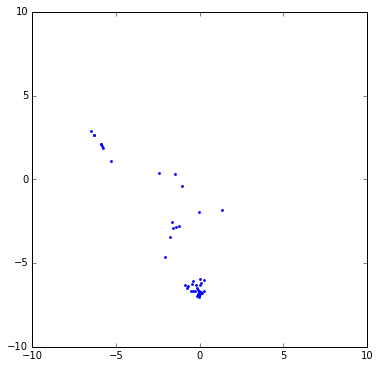

In [37]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 6
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size

plt.scatter([x[0] for x in word2_points], [y[1] for y in word2_points],s=8, c='b', lw=0, label='male')
plt.xlim(xmin=-10, xmax=10)
plt.ylim(ymin=-10, ymax=10)

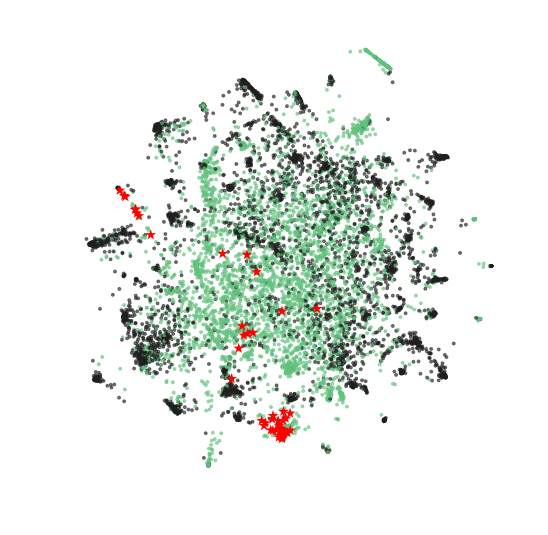

In [49]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 9
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size

colors = ['#63c17e' if percentages[i] >= 50 else '#1F1F1F' for i in range(0,10000)]

plt.scatter([x[0] for x in doc_xy_vectors],
            [y[1] for y in doc_xy_vectors],
            s=8, color=colors, lw=1, alpha=0.6)

plt.scatter([0], [0], s=8, color='#63c17e' , lw=1, label='female streamer only users', alpha=0.6)
 
plt.scatter([0], [1], s=8, color='#1F1F1F', lw=1, label='male streamer only users', alpha=0.6)
             
# plt.scatter([x[0] for x in word1_points], [y[1] for y in word1_points], s=128, c='r', lw=0,
#             label='similar to word \"points\"', marker='*', edgecolors='none')

plt.scatter([x[0] for x in word2_points], [y[1] for y in word2_points], s=128, c='r', lw=0,
            label='similar to word \"boobs\"', marker='*', edgecolors='none')
        
# leg = plt.legend(loc='lower left')
plt.axis('off')
savefig('user_clusters.png')

In [39]:
len([x[0] for i,x in enumerate(doc_xy_vectors) if percentages[i] >= 50],)

4712

In [40]:
len([x for x in percentages if x < 50])

5288